In [1]:
import re

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime
from collections import Counter


In [2]:
df_sbuzz = pd.read_csv("syndata/Box Office/Recruitment x Box Office x Q1 2019 - Twitter.csv", sep="\t")
df_title = pd.read_csv("syndata/Box Office/Recruitment x Box Office x Q1 2019 - Titles Performace.csv", sep="\t")

In [3]:
df_sbuzz = df_sbuzz.drop(axis=1, labels=['Unnamed: 0'])
df_sbuzz['title'] = df_sbuzz['title'].str.lower()

df_title['Title'] = df_title['Title'].str.lower()

df_sbuzz['post_date'] = pd.to_datetime([datetime.strptime(x[0], '%Y-%m-%d').date() for x in list(df_sbuzz['post_date_time'].str.split('T'))])
df_sbuzz['post_time'] = [datetime.strptime(x[1].split('.')[0], '%H:%M:%S').time() for x in list(df_sbuzz['post_date_time'].str.split('T'))]

In [4]:
movie_dict = {}
c = 0

for i in df_sbuzz.index:
    if df_sbuzz.at[i, 'title'] not in movie_dict:
        c+=1
        movie_dict[df_sbuzz.at[i, 'title']] = c

for i in df_title.index:
    if df_title.at[i, 'Title'] not in movie_dict:
        c+=1
        movie_dict[df_title.at[i, 'Title']] = c

In [5]:
#movie_dict

In [6]:
# reformatting should be done better
for i in df_title.index:
    dates = df_title.at[i, 'Date']
    reg_date = re.sub("[.]|[ ]", "", dates)
    dt_list = []
    
    for d1 in reg_date.split('–'):   
        d1 = re.sub("Sept", "Sep", d1)
        m1 = ''
        if len(d1) > 3:
            month = m1.join(re.findall("[a-zA-Z]", d1))
            day = m1.join(re.findall("[0-9]", d1))

            s = '{} {} {}'.format(month, day, df_title.at[i, 'Year'])
            dt_list.append(datetime.strptime(s, '%b %d %Y').date())
            
        else:
            s = '{} {} {}'.format(month, d1, df_title.at[i, 'Year'])
            dt_list.append(datetime.strptime(s, '%b %d %Y').date())

    df_title.at[i, 'begin_date'] = dt_list[0]
    df_title.at[i, 'end_date'] = dt_list[1]

    new_range = []
    default_range = range(0, 7)
    wk_range = range(dt_list[0].weekday(), dt_list[1].weekday())
    
    if wk_range.start > wk_range.stop:
        k = wk_range.start
        for _ in range(len(default_range)):
            new_range.append(default_range[k % len(default_range)])
            k+=1
    else:
        new_range = list(wk_range)
    
    df_title.at[i, 'has_weekend'] = 5 in new_range or 6 in new_range
    df_title.at[i, 'nth_week_number'] = dt_list[0].isocalendar()[1]
    df_title.at[i, 'movie_id_t'] = int(movie_dict[df_title.at[i, 'Title']])
    df_title.at[i, 'gross_to_date_float'] = float(re.sub('[^\d.]', '', df_title.at[i, 'Gross-to-Date']))
    

In [7]:
for i in df_sbuzz.index:
    df_sbuzz.at[i, 'movie_id_s'] = int(movie_dict[df_sbuzz.at[i, 'title']])
    df_sbuzz.at[i, 'nth_week_number'] = df_sbuzz.at[i, 'post_date'].isocalendar()[1]
    df_sbuzz.at[i, 'is_influencer'] = df_sbuzz.at[i, 'user_followers_count'] > 10000

In [8]:
#titles = list(df_title['Title'].unique())
#titles_buzz =  list(df_sbuzz['title'].unique())
#set(titles).intersection(titles_buzz)

In [9]:
df_title.head(5) 

,Title,Date,Year,Rank,Weekend Gross,Gross-to-Date,Week # of release,begin_date,end_date,has_weekend,nth_week_number,movie_id_t,gross_to_date_float
0,incredibles 2,Jun. 14–17,2018,1,"$7,898,856","$7,898,856",1,2018-06-14,2018-06-17,True,24.0,2.0,7898856.0
1,incredibles 2,Jun. 21–24,2018,2,"$4,868,158","$14,708,509",2,2018-06-21,2018-06-24,True,25.0,2.0,14708509.0
2,incredibles 2,Jun. 28–Jul. 1,2018,2,"$3,253,530","$19,313,351",3,2018-06-28,2018-07-01,True,26.0,2.0,19313351.0
3,incredibles 2,Jul. 5–8,2018,2,"$2,940,132","$24,578,641",4,2018-07-05,2018-07-08,True,27.0,2.0,24578641.0
4,incredibles 2,Jul. 12–15,2018,2,"$2,586,378","$29,501,312",5,2018-07-12,2018-07-15,True,28.0,2.0,29501312.0


In [10]:
# df_title.loc[df_title['has_weekend'].isna()]
# df_title.loc[df_title['Weekend Gross'].isna()]
# df_title.loc[df_title['nth_week_number'].isna()]
# df_sbuzz.loc[df_sbuzz['user_followers_count'].isna()]

In [11]:
# df_title.loc[df_title['Week # of release']==2]

In [12]:
df_sbuzz.sample(5)

,ID,title,post_link,post_date_time,post_content,user_name,user_bio,user_followers_count,user_followee_count,user_post_count,country,state,language,post_date,post_time,movie_id_s,nth_week_number,is_influencer
21651,1,black panther,http://twitter.com/Flavors_F/status/9658504094...,2018-02-20T07:27:36.000+0000,RT @UnarmedOracle I am intrigued by Black Pant...,Flavors_F,Welcome to Chateau Farley please grab a drink ...,216,232,64422,AUS,New South Wales,en,2018-02-20,07:27:36,4.0,8.0,False
68425,17,bright,http://twitter.com/KayeMenner/status/948331516...,2018-01-02T23:13:47.000+0000,RT @TexanInOz Anigozanthos ‘Big Red’ is probab...,KayeMenner,KAYE MENNER PHOTOGRAPHY - #Giftideas #Fine #a...,19607,14137,1574566,AUS,New South Wales,en,2018-01-02,23:13:47,17.0,1.0,True
54427,11,predator,http://twitter.com/Ausshot3Dave/status/1037685...,2018-09-06T12:53:55.000+0000,"RT @SarahRubyWrites @RachelBkr Me, to me: nono...",Ausshot3Dave,"Australian General News, Science & Technology,...",3416,4800,99884,AUS,Western Australia,it,2018-09-06,12:53:55,13.0,36.0,False
41145,8,coco,http://twitter.com/kcjade7150/status/957234595...,2018-01-27T12:51:26.000+0000,jennifer lopez porn sex nicole austin coco nud...,kcjade7150,"Female, 26 years old. My 2 daughters have my h...",19,22,9577,AUS,Queensland,es,2018-01-27,12:51:26,10.0,4.0,False
30665,5,wonder woman,http://twitter.com/irontomlinsons/status/87714...,2017-06-20T12:37:32.000+0000,RT @GalGadot Pure joy working on #WonderWoman ...,irontomlinsons,@Harry_Styles: It all comes out in the wash • ...,8133,4499,230781,AUS,South Australia,en,2017-06-20,12:37:32,7.0,25.0,False


In [13]:
followers_freq = df_sbuzz['user_followers_count'].value_counts(sort=True, ascending=True).to_dict()

In [14]:
max(followers_freq)

10883460

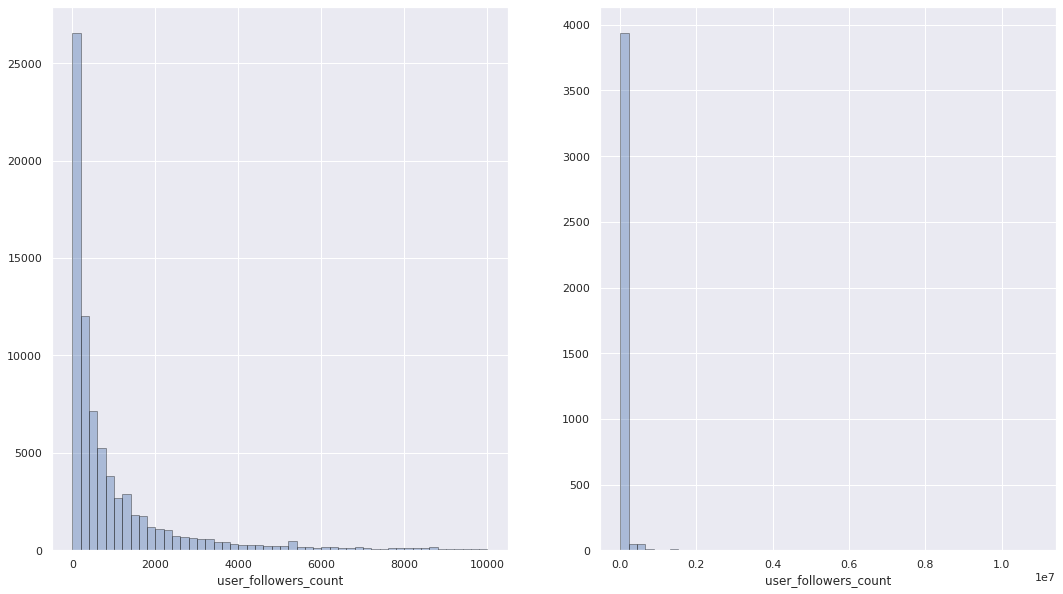

In [15]:
plt.rcParams['figure.figsize'] = [18, 10]
sns.set(color_codes=True)

plt.subplot(1, 2, 1)
sns.distplot(df_sbuzz['user_followers_count'][df_sbuzz['is_influencer']==False], kde=False, hist_kws=dict(edgecolor="k"));
plt.subplot(1, 2, 2)
sns.distplot(df_sbuzz['user_followers_count'][df_sbuzz['is_influencer']==True], kde=False, hist_kws=dict(edgecolor="k"));

# there are some outliers with influencer followers count

In [16]:
# sales performance across week number for different movies

# ax = sns.lineplot(y = 'Week # of release', x = 'gross_to_date_float', hue = 'Title', data = df_title, palette=sns.color_palette("colorblind", n_colors=19));
# for p in ax.patches:
#     print(p)
#     ax.annotate(str(p.get_height()), (p.get_x() *1.004, p.get_height() * 1.008))

# df_title[(df_title['Title']=='avengers: infinty war')]

In [17]:
by_week = (df_title
            .groupby(['Title', 'Week # of release'])
            .size()
            .unstack()
           )
# by_week

In [18]:
for idx in by_week.index:
    for col in by_week.columns:
        
        try:
            by_week.at[idx, col] = float(df_title[(df_title['Title']==idx) & (df_title['Week # of release']==col)]['gross_to_date_float'])
        except:
            by_week.at[idx, col] = np.nan

In [19]:
by_week.sample(5)

Week # of release,1,2,3,4,5,6,7,8,9,10,...,22,23,25,26,27,29,31,35,36,37
Title,,,,,,,,,,,,,,,,,,,,,
the meg,2606838.0,4823748.0,6007133.0,6624502.0,7012348.0,7253800.0,7300000.0,NaN,NaN,7300000.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
lion,3782546.0,8621529.0,12464938.0,15218741.0,17206071.0,NaN,NaN,21006973.0,21670863.0,21957499.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
avengers: infinty war,22698063.0,34397564.0,40500491.0,42973959.0,44502704.0,45539759.0,46352246.0,45785387.0,45875338.0,46691277.0,...,NaN,46822002.0,NaN,NaN,NaN,46825158.0,NaN,NaN,NaN,NaN
the predator,1705354.0,2988735.0,3661619.0,3854348.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
the grinch,3038185.0,5351180.0,8118799.0,11228173.0,12198283.0,12673800.0,13008579.0,13015625.0,13029004.0,13045703.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


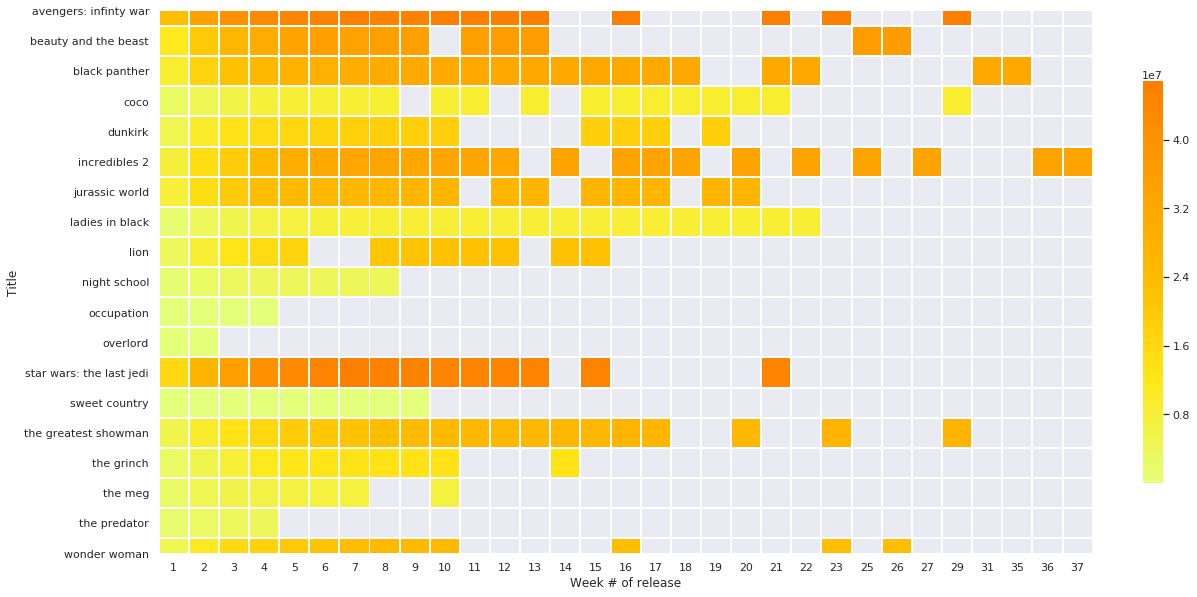

In [20]:
plt.figure(figsize=(18,10))
g = sns.heatmap(
    by_week, 
    square=True, 
    cbar_kws={'fraction' : 0.02}, 
    cmap='Wistia',
    linewidth=1 
)

In [21]:
# perform same heatmap analysis for nth week of the year sales